## Setup environment

In [1]:
!python -c "import monai" || pip install -q git+https://github.com/Project-MONAI/MONAI#egg=MONAI[gdown,ignite,torchvision,cucim]

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import os
import glob
import tempfile
import time
import torch
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, CacheDataset, GridPatchDataset, PatchIterd
from monai.inferers import sliding_window_inference
# from monai.losses import HoVerNetLoss
# from monai.networks.nets import HoVerNet
from monai.metrics import DiceMetric
from monai.transforms import (
    LoadImaged,
    Lambdad,
    Transposed,
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    RandCropByPosNegLabeld,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    RandFlipd,
    RandRotate90d,
    RandAffined,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    ThresholdIntensity,
    RandGridPatchd,
    GridPatchd,
    GaussianSmooth,
    FillHoles,
    BoundingRect,
    CenterSpatialCropd,
)
from monai.transforms.transform import MapTransform, RandomizableTransform
# from monai.apps.pathology.transforms.post.array import (
#     GenerateInstanceCentroid, 
#     GenerateInstanceContour, 
#     GenerateInstanceType,
# )
from monai.utils import set_determinism, convert_to_tensor, first
from monai.utils.enums import HoVerNetBranch, TransformBackends
from skimage import measure


print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.0.0+88.gb32d64cc
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b32d64ccede76ad92a7c79b051b99faa421d86a6
MONAI __file__: /workspace/Code/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
import sys
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/transforms')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/loss')
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/net')
from loss import HoVerNetLoss
from net import HoVerNet
from transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    Watershedd,
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
    GenerateInstanceCentroid, 
    GenerateInstanceContour, 
    GenerateInstanceType,
    RandShiftIntensityd,
)

## Setup data directory
You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/Data


## Process dataset

In [6]:
def prepare_data(data_dir, phase):
    data_dir = os.path.join(data_dir, 'train')

    files = sorted(
        glob.glob(os.path.join(data_dir, "*/*.npy")))

    images, labels, inst_maps, type_maps = [], [], [], []
    for file in files:
        data = np.load(file)
        images.append(data[..., :3].transpose(2, 0, 1))
        inst_maps.append(measure.label(data[..., 3][None]).astype(int))
        type_maps.append(data[..., 4][None])
        labels.append(np.array(data[..., 3][None] > 0, dtype=int))

    data_dicts = [
        {"image": _image, "label": _label, "label_inst": _inst_map, "label_type": _type_map}
        for _image, _label, _inst_map, _type_map in zip(images, labels, inst_maps, type_maps)
    ]

    return data_dicts

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [14]:
%load_ext autoreload
%autoreload 2

train_transforms = Compose(
    [
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 5]),
        CenterSpatialCropd(
            keys="image", 
            roi_size=(270, 270),
        ),
        CenterSpatialCropd(
            keys=["label", "label_inst", "label_type", "hover_label_inst"], 
            roi_size=(80, 80),
        ),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, spatial_axis=1),
        RandRotate90d(keys=["image", "label", "label_inst", "label_type", "hover_label_inst"], prob=0.5, max_k=1),
        RandGaussianSmoothd(keys=["image"], sigma_x=(0.5,1.15), sigma_y=(0.5,1.15), prob=0.5),
    ]
)
val_transforms = Compose(
    [
#         Lambdad(keys="image", func=lambda x: x[:3, ...]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 5]),
#         ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
#         RandAffined(
#             keys=["image", "label", "label_inst", "label_type", "hover_label_inst"],
#             prob=1.0,
#             rotate_range=((-np.pi) / 2, np.pi / 2),
#             scale_range=(0.8, 1.2),
#             shear_range=(-1, 1),
#             padding_mode="zeros",
#             mode="nearest",
#                   ),
        RandAdjustContrastd(keys=["image"], prob=1.0, gamma=(0.75,1.25)),
        CenterSpatialCropd(
            keys="image", 
            roi_size=(270, 270),
        ),
        CenterSpatialCropd(
            keys=["label", "label_inst", "label_type", "hover_label_inst"], 
            roi_size=(80, 80),
        ),
    ]
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Dataset and DataLoader for training and validation

In [15]:
from monai.data import GridPatchDataset, PatchIterd, ShuffleBuffer
from monai.transforms import ToMetaTensord

data_dir = "/workspace/Data/CoNSeP/Prepared/consep"
train_data = prepare_data(data_dir, "train")[:3]
valid_data = prepare_data(data_dir, "valid")[:3]

train_ds = CacheDataset(data=train_data, transform=train_transforms,
                    cache_rate=0.0, num_workers=4)
valid_ds = CacheDataset(data=valid_data, transform=val_transforms,
                    cache_rate=0.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size=16, num_workers=4, pin_memory=True)

## Check first data shape and visualize

image: 
    shape (2, 3, 270, 270)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
label: 
    shape (2, 2, 80, 80)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32
hover_label_inst: 
    shape (2, 2, 80, 80)
    type:  <class 'monai.data.meta_tensor.MetaTensor'>
    dtype:  torch.float32


Text(0.5, 1.0, 'vertical hover map')

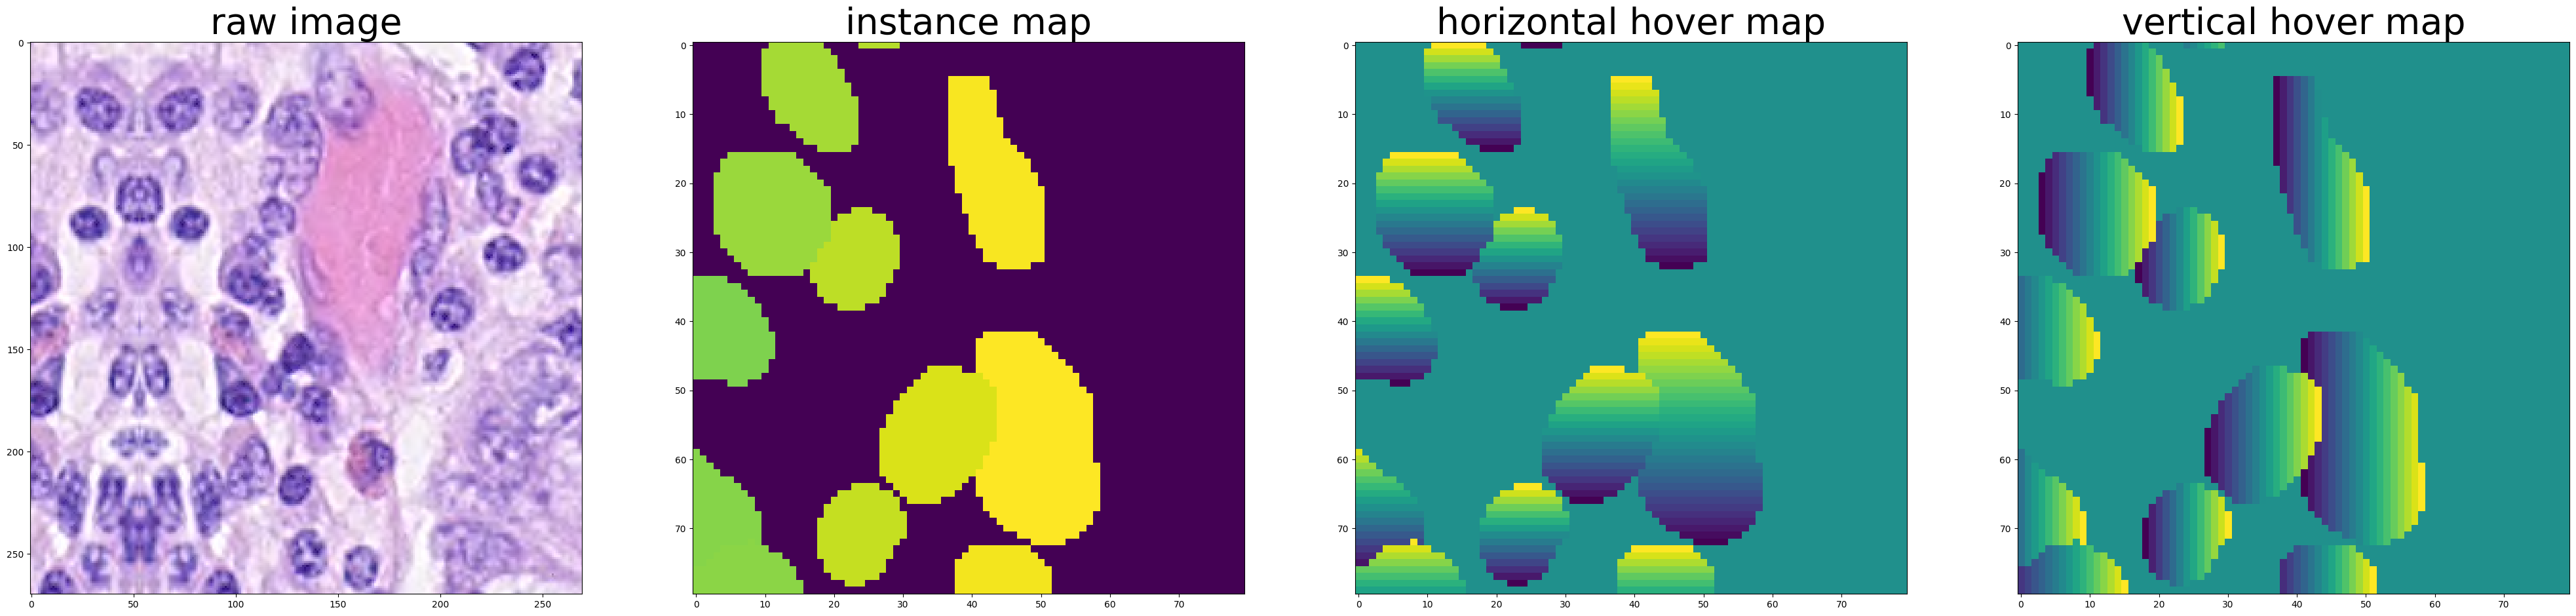

In [19]:
first_sample = first(train_loader)
for k in ("image", "label", "hover_label_inst"):
    print(f"{k}: ")
    print("    shape", first_sample[k].shape)
    print("    type: ", type(first_sample[k]))
    print("    dtype: ", first_sample[k].dtype)
# print(f"train number of batches: {len(train_loader)}")
# print(f"valid number of batches: {len(val_loader)}")

fig, ax = plt.subplots(1, 4, figsize=(50, 25))
ax[0].imshow((first_sample['image'][1, ...]).astype(np.uint8).transpose(1, 2, 0))
ax[1].imshow(first_sample['label_inst'][1, ...].squeeze())
ax[2].imshow(first_sample['hover_label_inst'][1, 0, ...])
ax[3].imshow(first_sample['hover_label_inst'][1, 1, ...])
ax[0].set_title('raw image', fontsize=40)
ax[1].set_title('instance map', fontsize=40)
ax[2].set_title('horizontal hover map', fontsize=40)
ax[3].set_title('vertical hover map', fontsize=40)

## Create Model, Loss, Optimizer

In [58]:
device = torch.device("cuda:1")
model = HoVerNet(
    mode="original",
    in_channels=3,
    out_classes=5,
    act=("relu", {"inplace": True}),
    norm="batch",
    pretrained=True,
).to(device)
model.freeze_encoder()
loss_function = HoVerNetLoss()

# original paper
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

# lizard dataset
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.0)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)

dice_metric = DiceMetric(include_background=False, reduction="mean")

2022-11-03 05:45:55,864 - INFO - Expected md5 is None, skip md5 check for file /root/.cache/torch/hub/preact-resnet50.pth.
2022-11-03 05:45:55,865 - INFO - File exists: /root/.cache/torch/hub/preact-resnet50.pth, skipped downloading.


## Execute a typical PyTorch training process

In [59]:
def post_process(output, device, return_binary=True, return_centroids=False, output_classes=None):
    post_trans_seg = Compose([
        GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
        GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=3),
        GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn=GaussianSmooth()),
        GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.7, radius=2, postprocess_fn=FillHoles()),
        Watershedd(keys='dist', mask_key='mask', markers_key='markers')
    ])
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(type_pred)

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background

    inst_info_dict = None
    if return_centroids:
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    if return_binary:
        pred_inst[pred_inst > 0] = 1
    return (pred_inst, inst_info_dict, pred_inst_dict)


In [60]:
max_epochs = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], []]
epoch_loss_values = []
metric_values = []

post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=2)])

total_start = time.time()
for epoch in range(max_epochs):
    if epoch > 50:
        model.res_blocks.requires_grad_(True)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, label, label_type, hover_map = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            batch_data["label_type"].to(device),
            batch_data["hover_label_inst"].to(device),
        )

        labels = {
            HoVerNetBranch.NP: label,
            HoVerNetBranch.HV: hover_map,
            HoVerNetBranch.NC: label_type,
        }
        optimizer.zero_grad()
        outputs = model(inputs)
        print(outputs[HoVerNetBranch.NP].shape, outputs[HoVerNetBranch.HV].shape, outputs[HoVerNetBranch.NC].shape)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if epoch > 1 and (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_label, val_label_type, val_hover_map = (
                    batch_data["image"].to(device),
                    batch_data["label"].to(device),
                    batch_data["label_type"].to(device),
                    batch_data["hover_label_inst"].to(device),
                )

                roi_size = (256, 256)
                sw_batch_size = 4
#                 val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = model(val_inputs)
#                 val_outputs = [post_pred(i['nucleus_prediction']) for i in decollate_batch(val_outputs)]
                val_outputs = [post_process(i, device=device)[0] for i in decollate_batch(val_outputs)]
                val_label = [i for i in decollate_batch(val_label)]

                dice_metric(y_pred=val_outputs, y=val_label)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(time.time() - total_start)
#                 torch.save(
#                     model.state_dict(),
#                     os.path.join(data_dir, "best_metric_model.pth"),
#                 )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/5
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
epoch 1 average loss: 9.4778
time consuming of epoch 1 is: 1.3084
----------
epoch 2/5
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
epoch 2 average loss: 8.1044
time consuming of epoch 2 is: 1.2737
----------
epoch 3/5
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
(2, 2, 80, 80) (2, 2, 80, 80) (2, 5, 80, 80)
epoch 3 average loss: 6.9563
saved new best metric model
current epoch: 3 current mean dice: 0.5631
best mean dice: 0.5631 at epoc

## Check best model output with the input image and label

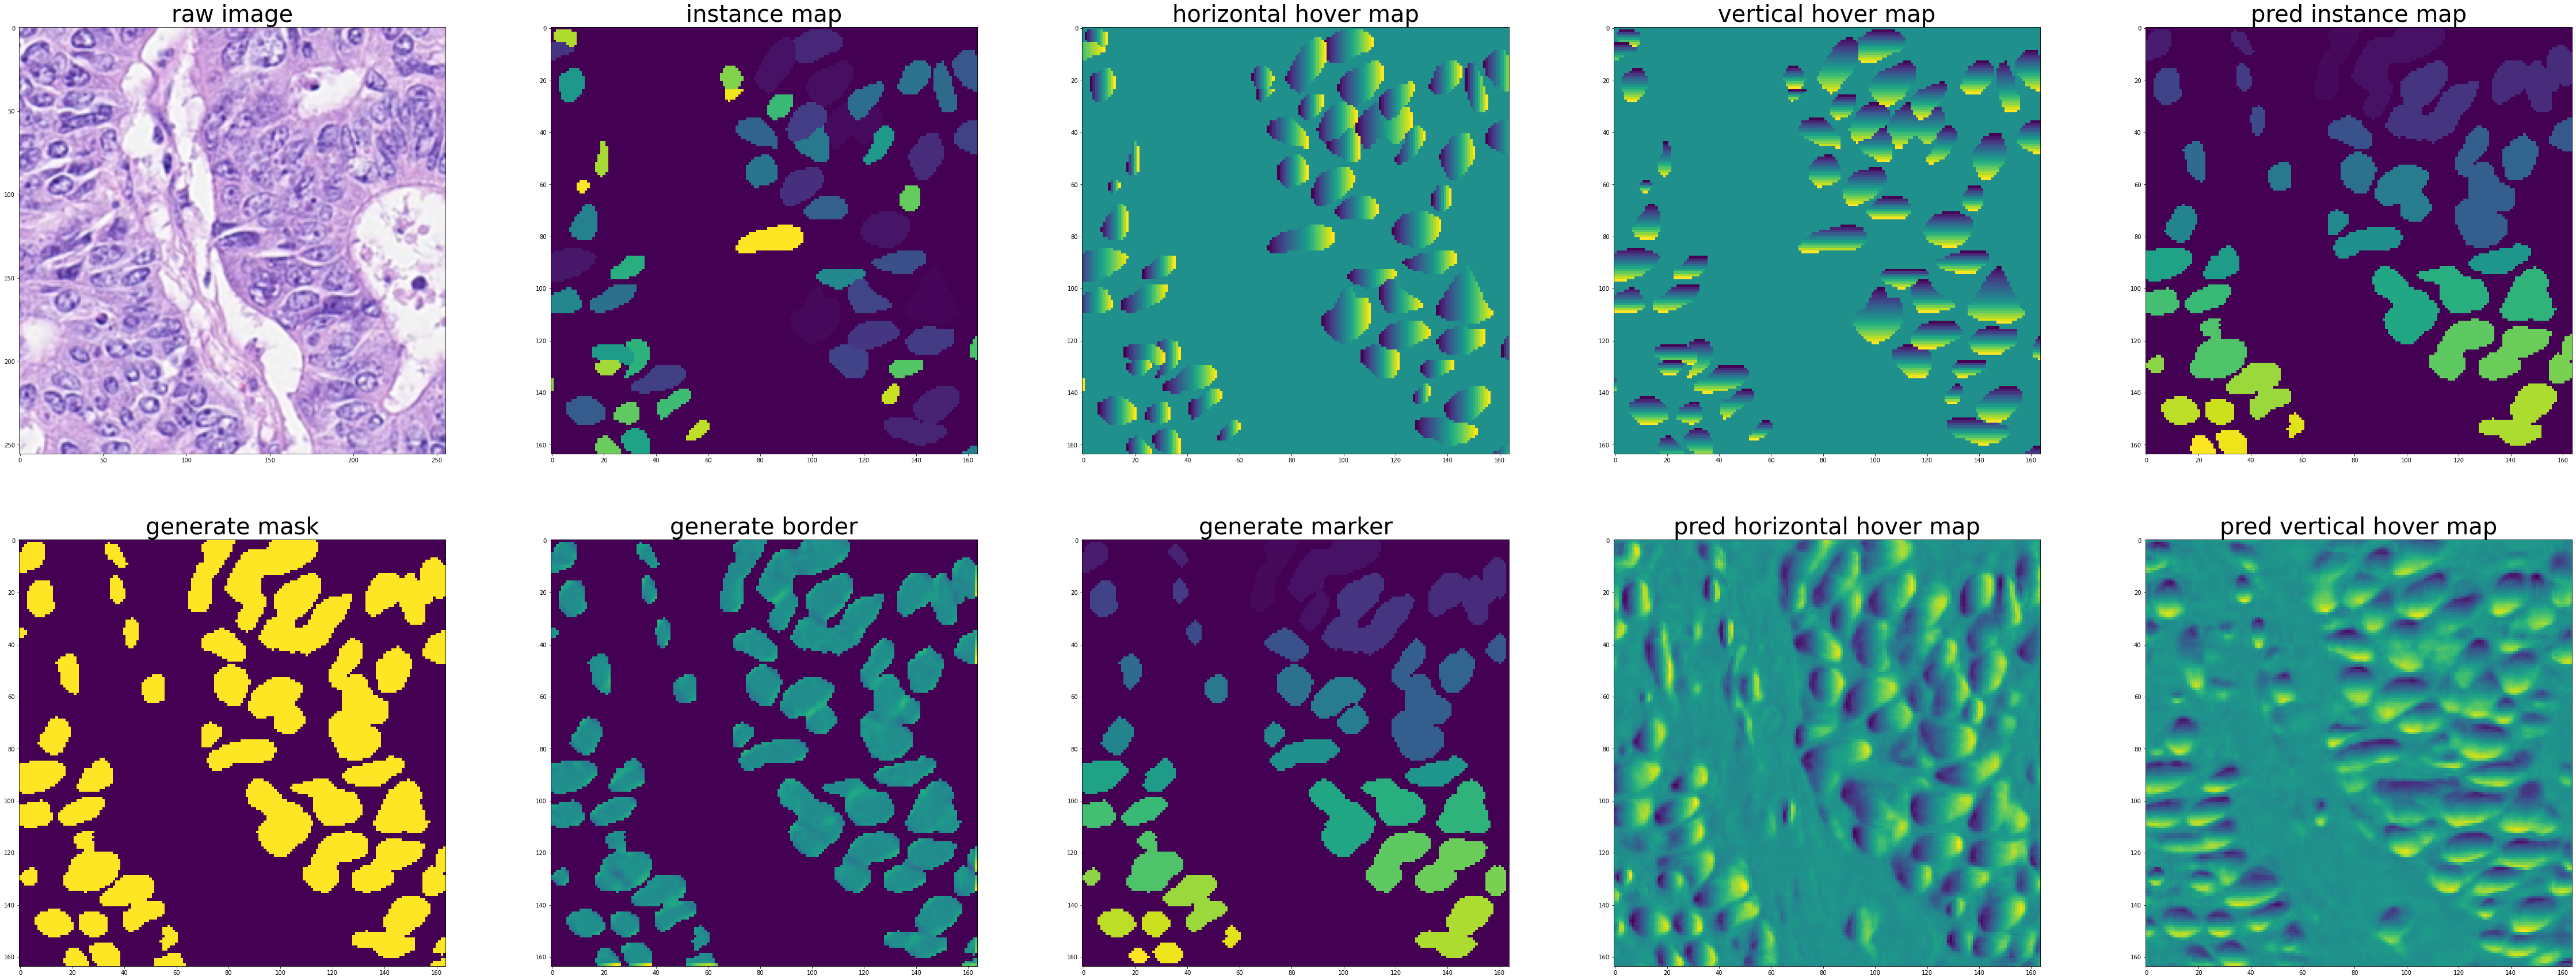

In [132]:
# test postprocess transform 
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = valid_ds[0]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output_ = [post_process(i) for i in decollate_batch(val_output)]

    fig, ax = plt.subplots(2, 5, figsize=(80, 30))
    ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].imshow(valid_ds[0]["label_inst"].squeeze().detach().cpu())
    ax[0, 2].imshow(valid_ds[0]["hover_label_inst"][0, ...].detach().cpu())
    ax[0, 3].imshow(valid_ds[0]["hover_label_inst"][1, ...].detach().cpu())
    ax[0, 4].imshow(val_output_[0][0].squeeze().detach().cpu())

    ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
    ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
    ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
    ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
    ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

    ax[0, 0].set_title('raw image', fontsize=40)
    ax[0, 1].set_title('instance map', fontsize=40)
    ax[0, 2].set_title('horizontal hover map', fontsize=40)
    ax[0, 3].set_title('vertical hover map', fontsize=40)
    ax[0, 4].set_title('pred instance map', fontsize=40)
    ax[1, 0].set_title('generate mask', fontsize=40)
    ax[1, 1].set_title('generate border', fontsize=40)
    ax[1, 2].set_title('generate marker', fontsize=40)
    ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
    ax[1, 4].set_title('pred vertical hover map', fontsize=40)

49


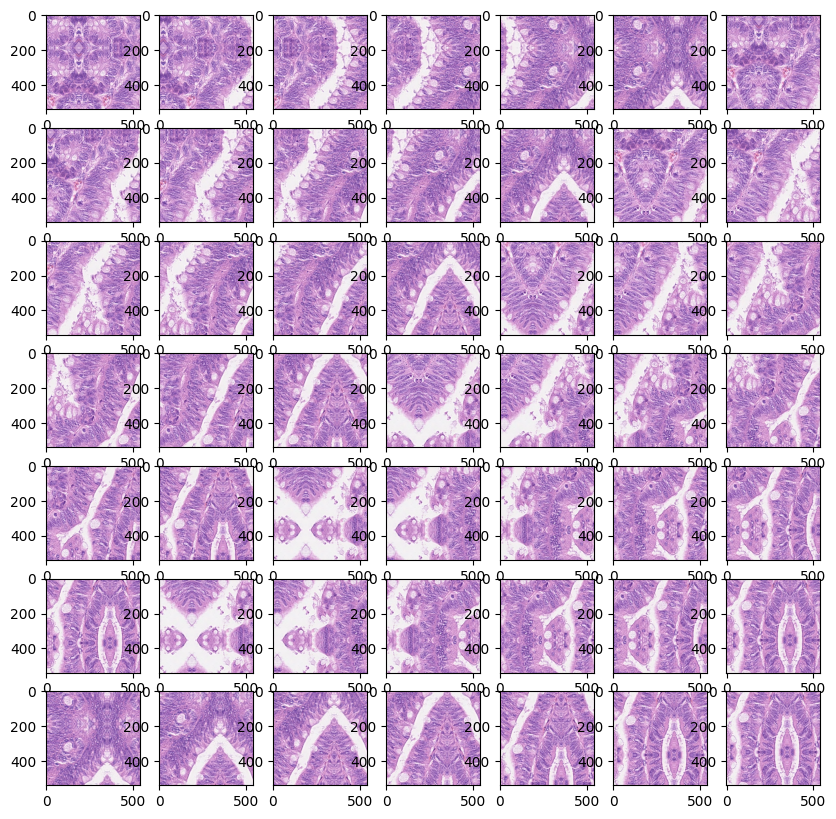

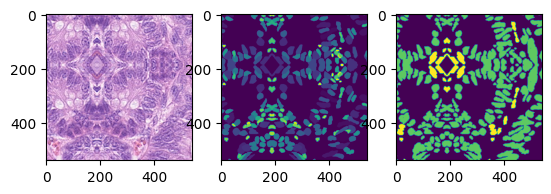

In [11]:
import glob
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path("/workspace/Data/CoNSeP/Prepared/consep/train/540x540_164x164")
data_list = list(root_path.iterdir())

case_13_patches = list(sorted(glob.glob(f"{root_path}/train_13*")))
print(len(case_13_patches))
arr1 = np.load(case_13_patches[0])

plt.figure(figsize=(10, 10)) 
for i in range(len(case_13_patches)):
    arr = np.load(case_13_patches[i])[..., :3]
    plt.subplot(7, 7, i+1)
    plt.imshow(arr)
plt.show()
plt.subplot(2, 3, 1)
plt.imshow(arr1[..., :3])
plt.subplot(2, 3, 2)
plt.imshow(arr1[..., 3])
plt.subplot(2, 3, 3)
plt.imshow(arr1[..., 4])
# plt.subplot(2, 3, 4)
# plt.imshow(arr2[..., :3])
# plt.subplot(2, 3, 5)
# plt.imshow(arr2[..., 3])
# plt.subplot(2, 3, 6)
# plt.imshow(arr2[..., 4])
plt.show()

In [27]:
import json
from pathlib import Path


stats_path = Path('/workspace/Data/CoNSeP/logs/01/stats.json')
with open(str(stats_path)) as f:
    file = json.load(f)

dice = []
for i in range(50):
    dice.append(file[str(i+1)]['valid-np_dice'])

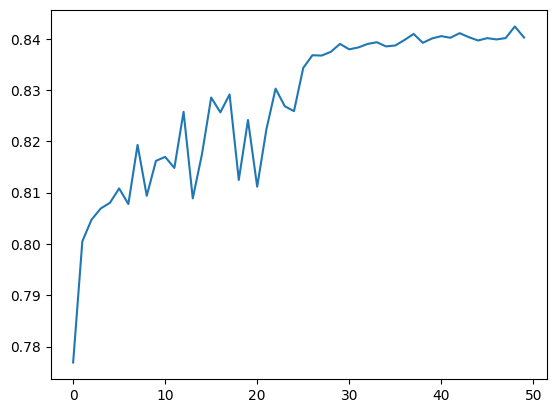

In [29]:
import matplotlib.pyplot as plt

plt.plot(dice)
plt.show()